In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# inspect Measurement table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017, 8 ,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.prcp, Measurement.date).\
                  filter(Measurement.date >= one_year).all()

month_precipitation = [{"Date": result[1], "Precipitation": result[0]} for result in results]

# Save the query results as a Pandas DataFrame and set the index to the date column
month_prcp_pd = pd.DataFrame(month_precipitation).set_index("Date")

# Sort the dataframe by date
month_prcp_pd = month_prcp_pd.sort_values(by=['Date'])


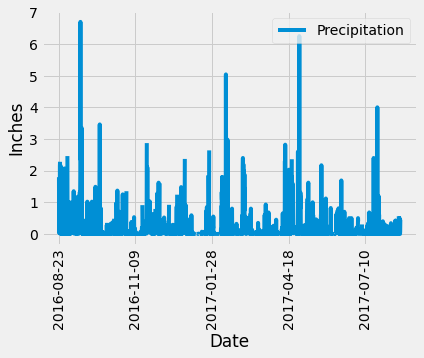

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
month_prcp_pd.plot()
plt.ylabel("Inches")
plt.xticks(rotation = 90)
plt.legend(loc='upper right')

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
month_prcp_pd.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# inspect Measurement table
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement).group_by(Measurement.station).count()

9

In [18]:
from sqlalchemy import desc
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

temperature = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()

temperature

[(<sqlalchemy.ext.automap.measurement object at 0x7fe14ec0f070>, 54.0, 85.0, 71.66378066378067)]

In [20]:
   # Create our session (link) from Python to the DB
session = Session(engine)
    #querey the data
sel = [Measurement, 
      func.min(Measurement.tobs), 
      func.max(Measurement.tobs), 
      func.avg(Measurement.tobs)]
    
temperature_start = session.query(*sel).\
    filter(Measurement.date >"2016-03-05").all()

temperature_start = list(np.ravel(temperature_start))

print(temperature_start)



[<sqlalchemy.ext.automap.measurement object at 0x7fe14ec19160>, 58.0, 87.0, 74.68574023614896]


In [25]:
temperature_start[1]

58.0

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs, Measurement.date).\
                  filter(Measurement.date >= one_year).filter(Measurement.station == "USC00519281").all()

month_temp = [{"Date": result[1], "Temperature": result[0]} for result in results]

month_temp_pd = pd.DataFrame(month_temp).set_index("Date")

# Sort the dataframe by date
month_temp_pd = month_temp_pd.sort_values(by=['Date'])

month_temp_pd.head(10)

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
2016-08-29,78.0
2016-08-30,77.0
2016-08-31,78.0


Text(0, 0.5, 'Frequency')

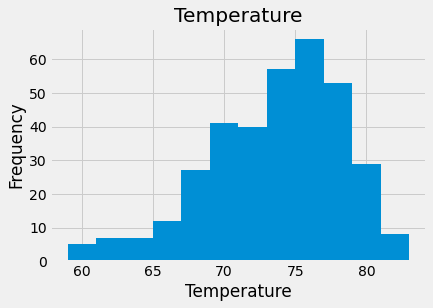

In [22]:
#plot the results as a histogram
month_temp_pd.hist(bins= 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Close session

In [23]:
# Close Session
session.close()